In [186]:
import pandas as pd
import numpy as np
from time import time
import json
from sqlalchemy import create_engine
import re
import datetime
import lifetimes
#import pymc3 as pm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact

In [187]:
# Set up the SQL connection
dbname = 'redshift'
url = 'panamera-ods.cnsuxis6zqxr.us-west-2.redshift.amazonaws.com:5439/panameraods'
engine = create_engine("postgresql://" + 'lucasdresl' + ":" + 'cQsY801a76x82x62aWDT' + "@" + url)

In [4]:
query_pk_in = """

select
  date_nk,
  count(distinct case when country_sk='olx|mea|pk' then session_long else null end) as dau_pk,
  count(distinct case when country_sk='olx|asia|in' then session_long else null end) as dau_in
   from ods.fact_user_hydra_browsing_activity
 where
     is_panamera = true
and channel_sk like '%android%'
and date_nk >= '2019-04-01'
group by 1
order by 1


"""

query_in_corrected = """

drop table if exists noDAU;
select
   date_event_nk,session_long
into temp table noDAU
    from ods.panameraolx_asia_hydra_ninja_android_201907
where date_event_nk > '2019-07-05'
group by 1,2
having sum(case when trackevent in ('app_open', 'on_create', 'apps', 'push_dis','pushDis', 'push_rcv', 'pushRcv', 'UAReg', 'ua_reg', 'uareg','push_dismissed', 'push_show','fetching_matrix', 'not_found','permissions_impression','userBadgeCount','test_assignment','test_impression','test_discovered','FCMReg','APNSReg','appOpn','appOpen','google_play_services','fetchTestDefinitionsError','messages_scheduler_ended','messages_scheduler_started')
       then 0 else 1 end) = 0;
select
   date_nk, count(distinct a.session_long) as exDAU, -- dau inflado
       count(distinct case when b.session_long is null then a.session_long else null end) as DAU -- dau posta
    from ods.fact_user_hydra_browsing_activity a
left join noDAU b
on a.session_long=b.session_long and a.date_nk= b.date_event_nk
where a.date_nk > '2019-07-10'
and country_sk = 'olx|asia|in' -- Pais
and channel_sk like '%android%'
group by 1
order by 1 desc;

"""


In [5]:
df = pd.read_sql_query(query_pk_in.replace('%', '%%'), engine)
df_correc = pd.read_sql_query(query_in_corrected.replace('%', '%%'), engine)

In [6]:
df = df.sort_values(['date_nk'])

In [7]:
df = pd.merge(df , df_correc , how='left' , on=['date_nk'])

In [8]:
df['dau_india'] = np.where(df['dau'].isnull() , df['dau_in'] , df['dau'])

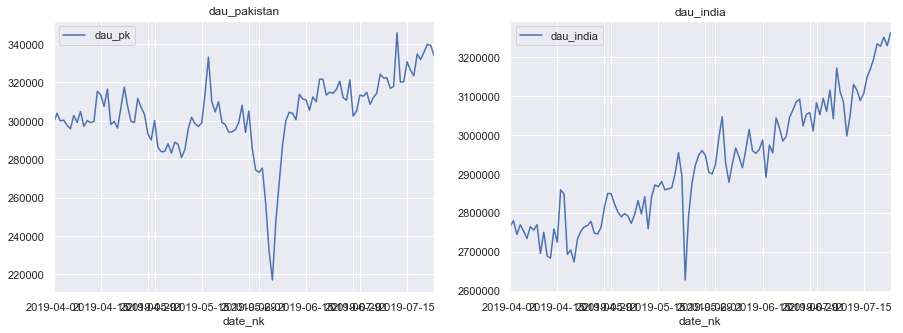

In [9]:
dfplot = df[['date_nk' , 'dau_pk' , 'dau_india']]
dfplot = dfplot.set_index('date_nk')
fig , (ax1 , ax2) = plt.subplots(1,2,figsize=(15,5))
dfplot[['dau_pk']].plot(ax=ax1 , title = 'dau_pakistan')
dfplot[['dau_india']].plot(ax=ax2 , title = 'dau_india')

In [10]:
casualdf = df[['dau_india' , 'dau_pk']]
casualdf.head()

,dau_india,dau_pk
0,2764788.0,298647
1,2779618.0,303980
2,2744147.0,299901
3,2768987.0,300433
4,2753217.0,297697


In [11]:
casualdf.dau_india = casualdf.dau_india.astype(int)

In [12]:
casualdf.dtypes

dau_india    int64
dau_pk       int64
dtype: object

In [13]:
dfcasual = pd.DataFrame(
    {'y': casualdf['dau_india'],
     'x1': casualdf['dau_pk']
    }
)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


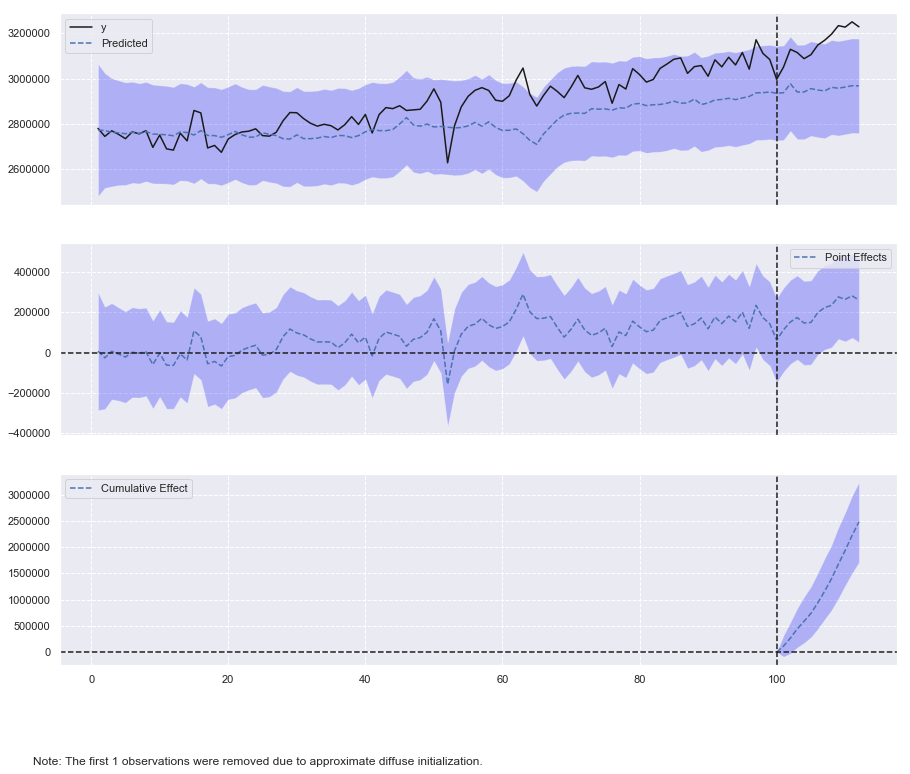

In [14]:
pre_period = [0, 100]
post_period = [101, 112]
ci = CausalImpact(dfcasual, pre_period, post_period)
#print(ci.summary())
ci.plot()

### Time series

In [15]:
from pandas.plotting import autocorrelation_plot

In [16]:
df.to_csv('dau_india.csv')

In [17]:
df.tail(30)

,date_nk,dau_pk,dau_in,exdau,dau,dau_india
84,2019-06-24,316374,3064263,NaN,NaN,3064263.0
85,2019-06-25,320665,3085334,NaN,NaN,3085334.0
86,2019-06-26,312122,3091361,NaN,NaN,3091361.0
87,2019-06-27,310730,3022988,NaN,NaN,3022988.0
88,2019-06-28,321348,3052762,NaN,NaN,3052762.0
89,2019-06-29,302476,3057489,NaN,NaN,3057489.0
90,2019-06-30,305177,3010358,NaN,NaN,3010358.0
91,2019-07-01,313457,3082834,NaN,NaN,3082834.0
92,2019-07-02,312859,3051803,NaN,NaN,3051803.0
93,2019-07-03,314888,3094378,NaN,NaN,3094378.0


In [18]:
# Hasta el '2019-06-25'
india = df['dau_india'][0:85]

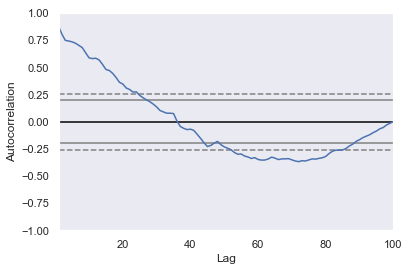

In [19]:
autocorrelation_plot(india)

In [20]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

                             ARIMA Model Results                              
Dep. Variable:            D.dau_india   No. Observations:                   99
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1211.736
Method:                       css-mle   S.D. of innovations          49848.322
Date:                Wed, 24 Jul 2019   AIC                           2437.472
Time:                        12:05:48   BIC                           2455.637
Sample:                             1   HQIC                          2444.822
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3555.1372   1796.533      1.979      0.051      33.997    7076.278
ar.L1.D.dau_india    -0.4713      0.099     -4.775      0.000      -0.665      -0.278
ar.L2.D.dau_india    -0.

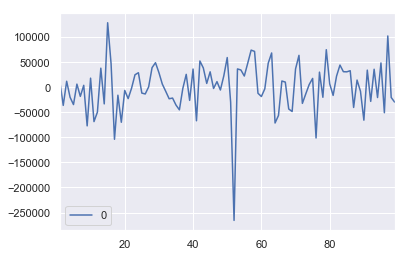

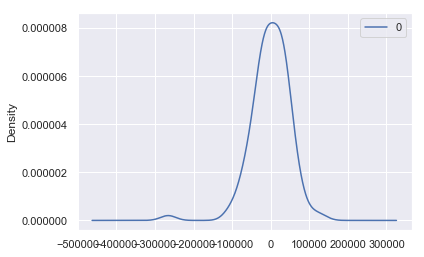

                   0
count      99.000000
mean     -335.962438
std     50140.513133
min   -265731.193899
25%    -24641.715901
50%      3809.589939
75%     31947.587604
max    128647.361955


In [21]:
# fit model
model = ARIMA(india, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [22]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [23]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(india)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.502044
p-value: 0.984935


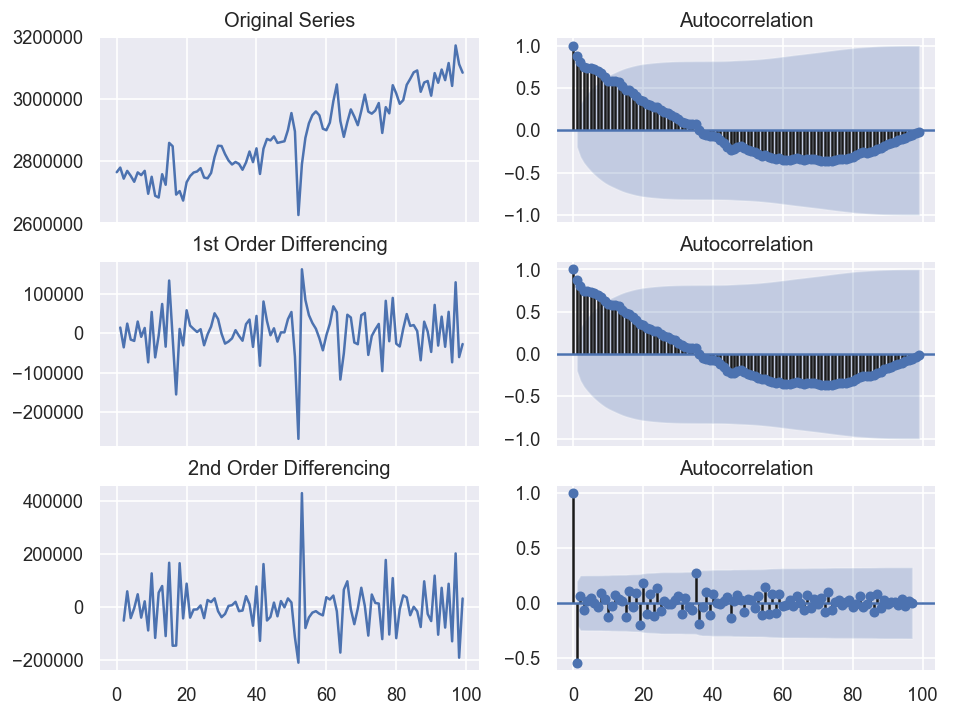

In [24]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(india); axes[0, 0].set_title('Original Series')
plot_acf(india, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(india.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(india.dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(india.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(india.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

AR

/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


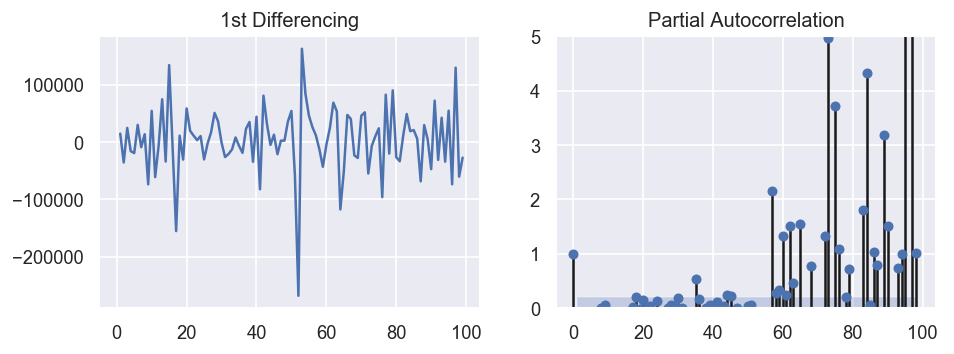

In [25]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(india.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(india.diff().dropna(), ax=axes[1])

plt.show()

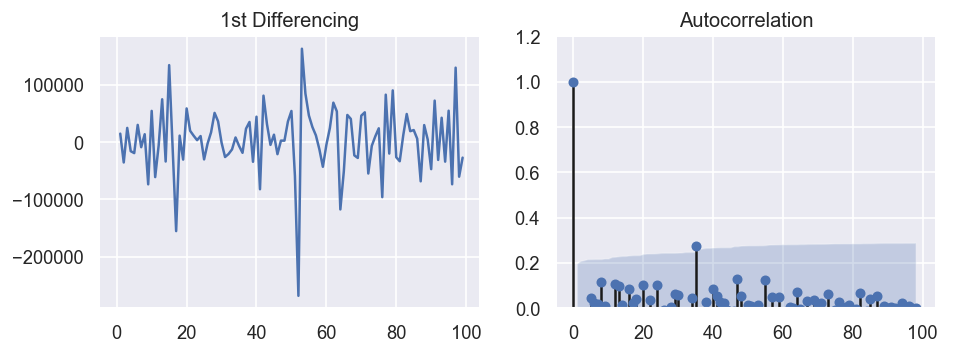

In [26]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(india.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(india.diff().dropna(), ax=axes[1])

plt.show()

In [74]:
# 1,1,2 ARIMA Model
model = ARIMA(india.diff().dropna(), order=(1,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:              dau_india   No. Observations:                   83
Model:                     ARMA(1, 2)   Log Likelihood               -1014.447
Method:                       css-mle   S.D. of innovations          48074.475
Date:                Wed, 24 Jul 2019   AIC                           2038.895
Time:                        12:32:25   BIC                           2050.989
Sample:                             0   HQIC                          2043.753
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3550.5487    325.786     10.898      0.000    2912.019    4189.078
ar.L1.dau_india     0.1392      0.230      0.605      0.547      -0.312       0.590
ma.L1.dau_india    -0.6849      

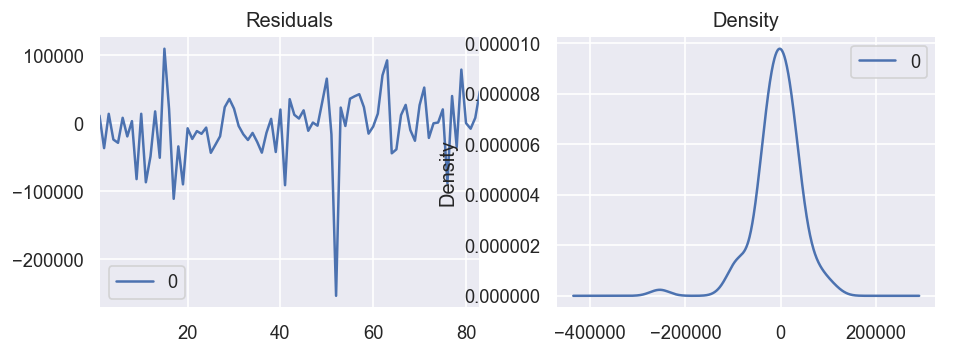

In [75]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

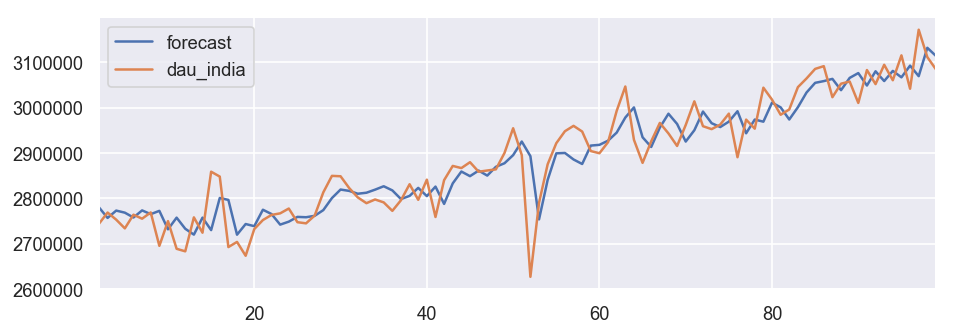

In [29]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [30]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(india.diff().dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=365,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 365); AIC=2455.520, BIC=2460.710, Fit time=0.173 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 365); AIC=2451.371, BIC=2459.157, Fit time=0.024 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit AR

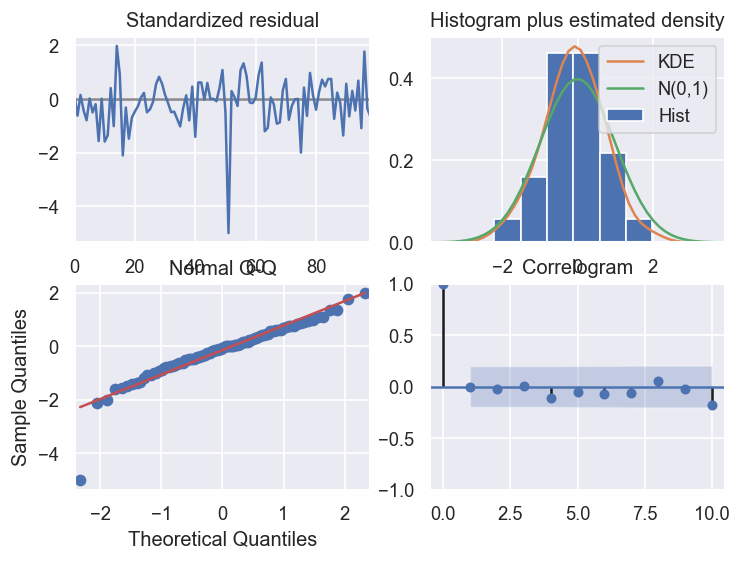

In [31]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

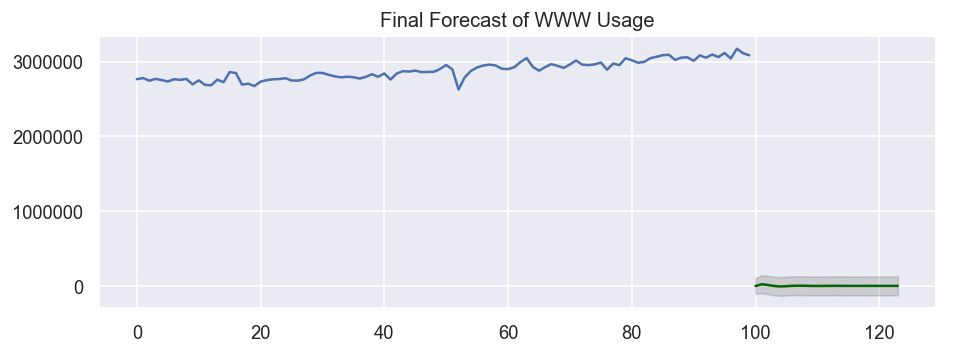

In [32]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(india), len(india)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(india)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

In [33]:
fc

array([ 3750.41913218, 27102.4346526 , 17465.84860738,  4212.22771512,
       -2383.64338742,  1139.1114422 ,  6178.92760295,  8126.32270137,
        6730.26293185,  4895.459992  ,  4320.92124589,  4880.42036591,
        5535.0631901 ,  5699.35312928,  5477.30830314,  5246.63392228,
        5202.5351676 ,  5289.41921386,  5369.89246733,  5380.37067683,
        5346.84129511,  5319.03115191,  5317.19546536,  5329.97327655])

In [34]:
train = india[:int(0.8*(len(india)))]
test = india[int(0.8*len(india))]

In [35]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=5,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 5); AIC=1905.167, BIC=1916.754, Fit time=0.334 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 5); AIC=1900.729, BIC=1905.364, Fit time=0.019 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 5); AIC=1903.963, BIC=1913.233, Fit time=0.165 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 5); AIC=1903.351, BIC=1912.621, Fit time=0.124 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 5); AIC=1901.094, BIC=1908.047, Fit time=0.052 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 1, 5); AIC=1901.023, BIC=1907.976, Fit time=0.102 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 1, 5); AIC=1901.951, BIC=1911.221, Fit time=0.288 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 5); AIC=1904.400, BIC=1911.353, Fit time=0.036 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 0, 5); AIC=1903.952, BIC=1910.904, Fit time=0.064 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_o

predicted=2904191.723251, expected=2925793.000000
predicted=2950518.560743, expected=2966324.000000
predicted=2996957.331458, expected=2943212.000000
predicted=2959445.757825, expected=2915604.000000
predicted=2916875.074646, expected=2961816.000000
predicted=2953070.027627, expected=3013877.000000
predicted=2996397.555998, expected=2959121.000000
predicted=2958106.554782, expected=2952640.000000
predicted=2957042.297127, expected=2962659.000000
predicted=2965575.542788, expected=2986786.000000
predicted=2996120.281371, expected=2890785.000000
predicted=2926745.872083, expected=2973620.000000
predicted=2983187.479279, expected=2953660.000000
predicted=2956283.610877, expected=3043955.000000
predicted=3018584.920692, expected=3017643.000000
predicted=2992823.143211, expected=2984315.000000
predicted=2975139.770377, expected=2996017.000000
predicted=2998360.846097, expected=3045141.000000
predicted=3037399.445439, expected=3064263.000000
predicted=3053342.811895, expected=3085334.000000


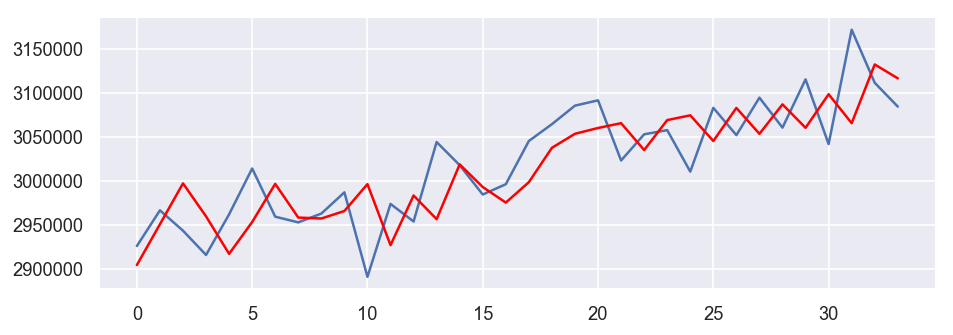

In [36]:
X = india.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [44]:
df.tail(30)

,date_nk,dau_pk,dau_in,exdau,dau,dau_india
84,2019-06-24,316374,3064263,NaN,NaN,3064263.0
85,2019-06-25,320665,3085334,NaN,NaN,3085334.0
86,2019-06-26,312122,3091361,NaN,NaN,3091361.0
87,2019-06-27,310730,3022988,NaN,NaN,3022988.0
88,2019-06-28,321348,3052762,NaN,NaN,3052762.0
89,2019-06-29,302476,3057489,NaN,NaN,3057489.0
90,2019-06-30,305177,3010358,NaN,NaN,3010358.0
91,2019-07-01,313457,3082834,NaN,NaN,3082834.0
92,2019-07-02,312859,3051803,NaN,NaN,3051803.0
93,2019-07-03,314888,3094378,NaN,NaN,3094378.0


In [54]:
df['uno'] = 1
df['cumuno'] = df['uno'].cumsum()
df.tail(30)

,date_nk,dau_pk,dau_in,exdau,dau,dau_india,uno,cumuno
84,2019-06-24,316374,3064263,NaN,NaN,3064263.0,1,85
85,2019-06-25,320665,3085334,NaN,NaN,3085334.0,1,86
86,2019-06-26,312122,3091361,NaN,NaN,3091361.0,1,87
87,2019-06-27,310730,3022988,NaN,NaN,3022988.0,1,88
88,2019-06-28,321348,3052762,NaN,NaN,3052762.0,1,89
89,2019-06-29,302476,3057489,NaN,NaN,3057489.0,1,90
90,2019-06-30,305177,3010358,NaN,NaN,3010358.0,1,91
91,2019-07-01,313457,3082834,NaN,NaN,3082834.0,1,92
92,2019-07-02,312859,3051803,NaN,NaN,3051803.0,1,93
93,2019-07-03,314888,3094378,NaN,NaN,3094378.0,1,94


In [55]:
india = df[df['cumuno'] < 85].dau_india

In [56]:
model = ARIMA(india.diff().dropna(), order=(5,1,0))
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps=10)

In [57]:
output

(array([3037399.44543898, 3037259.3441067 , 3031789.10305807,
        3029261.45773303, 3037044.86875167, 3047514.94858531,
        3051680.07919597, 3052971.80909992, 3053539.05275394,
        3055814.71385401]),
 array([50862.08975909, 59325.27089656, 61433.38751045, 62374.45553049,
        63448.68444238, 65995.2758504 , 70473.37696743, 74008.63958457,
        76272.28784519, 77998.07629759]),
 array([[2937711.58133272, 3137087.30954524],
        [2920983.94977636, 3153534.73843703],
        [2911381.87608929, 3152196.33002684],
        [2907009.77133797, 3151513.14412808],
        [2912687.73237815, 3161402.00512519],
        [2918166.58476874, 3176863.31240187],
        [2913554.7984709 , 3189805.35992105],
        [2907917.54096937, 3198026.07723048],
        [2904048.11555891, 3203029.98994898],
        [2902941.29344733, 3208688.13426069]]))

In [37]:
df.tail(30)

,date_nk,dau_pk,dau_in,exdau,dau,dau_india
84,2019-06-24,316374,3064263,NaN,NaN,3064263.0
85,2019-06-25,320665,3085334,NaN,NaN,3085334.0
86,2019-06-26,312122,3091361,NaN,NaN,3091361.0
87,2019-06-27,310730,3022988,NaN,NaN,3022988.0
88,2019-06-28,321348,3052762,NaN,NaN,3052762.0
89,2019-06-29,302476,3057489,NaN,NaN,3057489.0
90,2019-06-30,305177,3010358,NaN,NaN,3010358.0
91,2019-07-01,313457,3082834,NaN,NaN,3082834.0
92,2019-07-02,312859,3051803,NaN,NaN,3051803.0
93,2019-07-03,314888,3094378,NaN,NaN,3094378.0


In [38]:
india_previo = df['dau_india'][0:85]

In [39]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

X = india_previo.values
days_in_year = 1
differenced = difference(X, days_in_year)

# fit model
model = ARIMA(differenced, order=(1,1,0))
model_fit = model.fit(disp=0)
# multi-step out-of-sample forecast
start_index = len(differenced)
end_index = start_index + 15
forecast = model_fit.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 3078694.224254
Day 2: 3071865.906054
Day 3: 3075209.439052
Day 4: 3073686.143094
Day 5: 3074491.432526
Day 6: 3074182.585840
Day 7: 3074406.809273
Day 8: 3074375.979713
Day 9: 3074467.182933
Day 10: 3074499.998290
Day 11: 3074560.749932
Day 12: 3074608.135166
Day 13: 3074661.915698
Day 14: 3074712.636332
Day 15: 3074764.821007
Day 16: 3074816.305196


In [40]:
X

array([2764788., 2779618., 2744147., 2768987., 2753217., 2734087.,
       2764206., 2755393., 2769190., 2695569., 2750099., 2689083.,
       2683516., 2758316., 2724502., 2858900., 2848153., 2692884.,
       2704246., 2673750., 2732568., 2752413., 2763708., 2767161.,
       2777797., 2747674., 2745163., 2762316., 2813405., 2849747.,
       2848849., 2822873., 2802187., 2789575., 2797736., 2791296.,
       2772630., 2796075., 2831299., 2797000., 2841380., 2759167.,
       2840296., 2871645., 2866864., 2879829., 2858847., 2861525.,
       2864094., 2900243., 2954613., 2895561., 2627393., 2790415.,
       2875226., 2921662., 2948051., 2959875., 2947356., 2904375.,
       2899517., 2924044., 2992917., 3046513., 2929084., 2878336.,
       2925793., 2966324., 2943212., 2915604., 2961816., 3013877.,
       2959121., 2952640., 2962659., 2986786., 2890785., 2973620.,
       2953660., 3043955., 3017643., 2984315., 2996017., 3045141.,
       3064263.])

### Prophet

In [76]:
import fbprophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [83]:
df['ds'] = df['date_nk']
df['y'] = df['dau_india']

In [88]:
df.head()

,date_nk,dau_pk,dau_in,exdau,dau,dau_india,uno,cumuno,ds,y
0,2019-04-01,298647,2764788,NaN,NaN,2764788.0,1,1,2019-04-01,2764788.0
1,2019-04-02,303980,2779618,NaN,NaN,2779618.0,1,2,2019-04-02,2779618.0
2,2019-04-03,299901,2744147,NaN,NaN,2744147.0,1,3,2019-04-03,2744147.0
3,2019-04-04,300433,2768987,NaN,NaN,2768987.0,1,4,2019-04-04,2768987.0
4,2019-04-05,297697,2753217,NaN,NaN,2753217.0,1,5,2019-04-05,2753217.0


In [93]:
dfs = df[['date_nk','ds' , 'y']]
dfs = dfs.set_index('date_nk')

In [94]:
dfs.head()

,ds,y
date_nk,,
2019-04-01,2019-04-01,2764788.0
2019-04-02,2019-04-02,2779618.0
2019-04-03,2019-04-03,2744147.0
2019-04-04,2019-04-04,2768987.0
2019-04-05,2019-04-05,2753217.0


In [108]:
df_for_prohphet = dfs[0:101]

In [110]:
m = fbprophet.Prophet()

In [111]:
m.fit(df_for_prohphet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [112]:
future = m.make_future_dataframe(periods=14)

In [113]:
forecast = m.predict(future)

In [114]:
forecast.to_csv('prophet.csv')

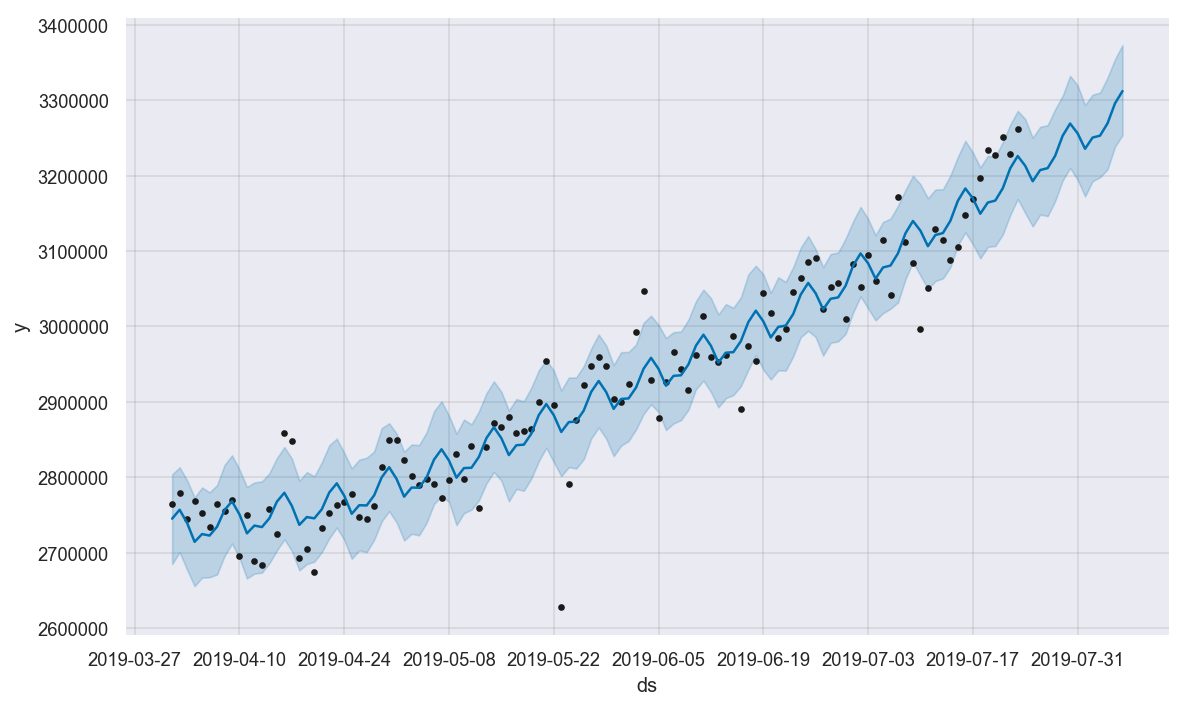

In [99]:
m.plot(forecast);

In [188]:
query_in = """

select
  date_nk,
  count(distinct case when user_active_new_returning_nk = 'new' then session_long else null end) as new_users,
  count(distinct session_long) as total_users
  from ods.fact_user_hydra_browsing_activity
 where is_panamera = true
   and date_nk > '2019-04-01'
   and country_sk in ('olx|asia|in')
   and channel_sk like '%android%'
  group by 1
  order by 1

"""


In [189]:
dft = pd.read_sql_query(query_in.replace('%', '%%'), engine)

In [190]:
dft['returning_users'] = dft['total_users'] - dft['new_users']

In [191]:
dft = dft.sort_values(['date_nk'])

In [192]:
dft.head()

,date_nk,new_users,total_users,returning_users
0,2019-04-02,209261,2779618,2570357
1,2019-04-03,201661,2744147,2542486
2,2019-04-04,202639,2768987,2566348
3,2019-04-05,193663,2753217,2559554
4,2019-04-06,203454,2734087,2530633


In [193]:
dft.to_csv('new_and_returning.csv')

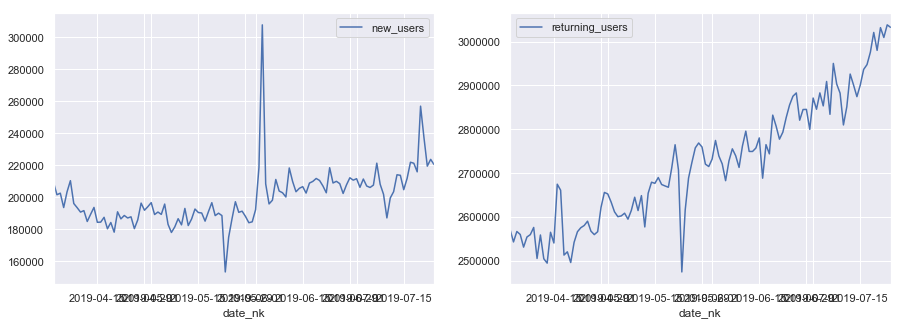

In [194]:
dft_plot_return_and_new = dft[['date_nk' , 'new_users' , 'returning_users']]
dft_plot_return_and_new = dft_plot_return_and_new.set_index('date_nk')

fig , (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

dft_plot_return_and_new[['new_users']].plot(ax=ax1)
dft_plot_return_and_new[['returning_users']].plot(ax=ax2)
ax1.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=90)




In [177]:
dft_return = dft[['date_nk' , 'returning_users']]

In [178]:
dft_return['ds'] = dft_return['date_nk']
dft_return['y'] = dft_return['returning_users']

In [179]:
dfs = dft_return[['date_nk','ds' , 'y']]
dfs = dfs.set_index('date_nk')

In [180]:
india = dfs[0:100]

In [181]:
m = fbprophet.Prophet()

In [182]:
m.fit(india)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [183]:
future = m.make_future_dataframe(periods=14)

In [184]:
forecast = m.predict(future)

In [185]:
forecast.to_csv('prophet_returning.csv')

In [ ]:
dft['ds'] = df['date_nk']
dft['y'] = df['dau_india']